In [8]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import plot_model
import pydot
import graphviz
import random
from src.data_handler import MNISTAdditionDataset
from src.visualization import plot_sample_additions, plot_training_history, plot_confusion_matrix, visualize_incorrect_predictions
from src.plot_settings import set_publication_style, format_axis_ticks, save_publication_figure

# Set plot style for publication quality
set_publication_style()

# Set random seed to ensure reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Load and Validate Data

Data shapes:
Training images: (50000, 28, 56)
Training labels: (50000,)

Value ranges:
Image min: 0.000, max: 1.000
Label min: 0, max: 18


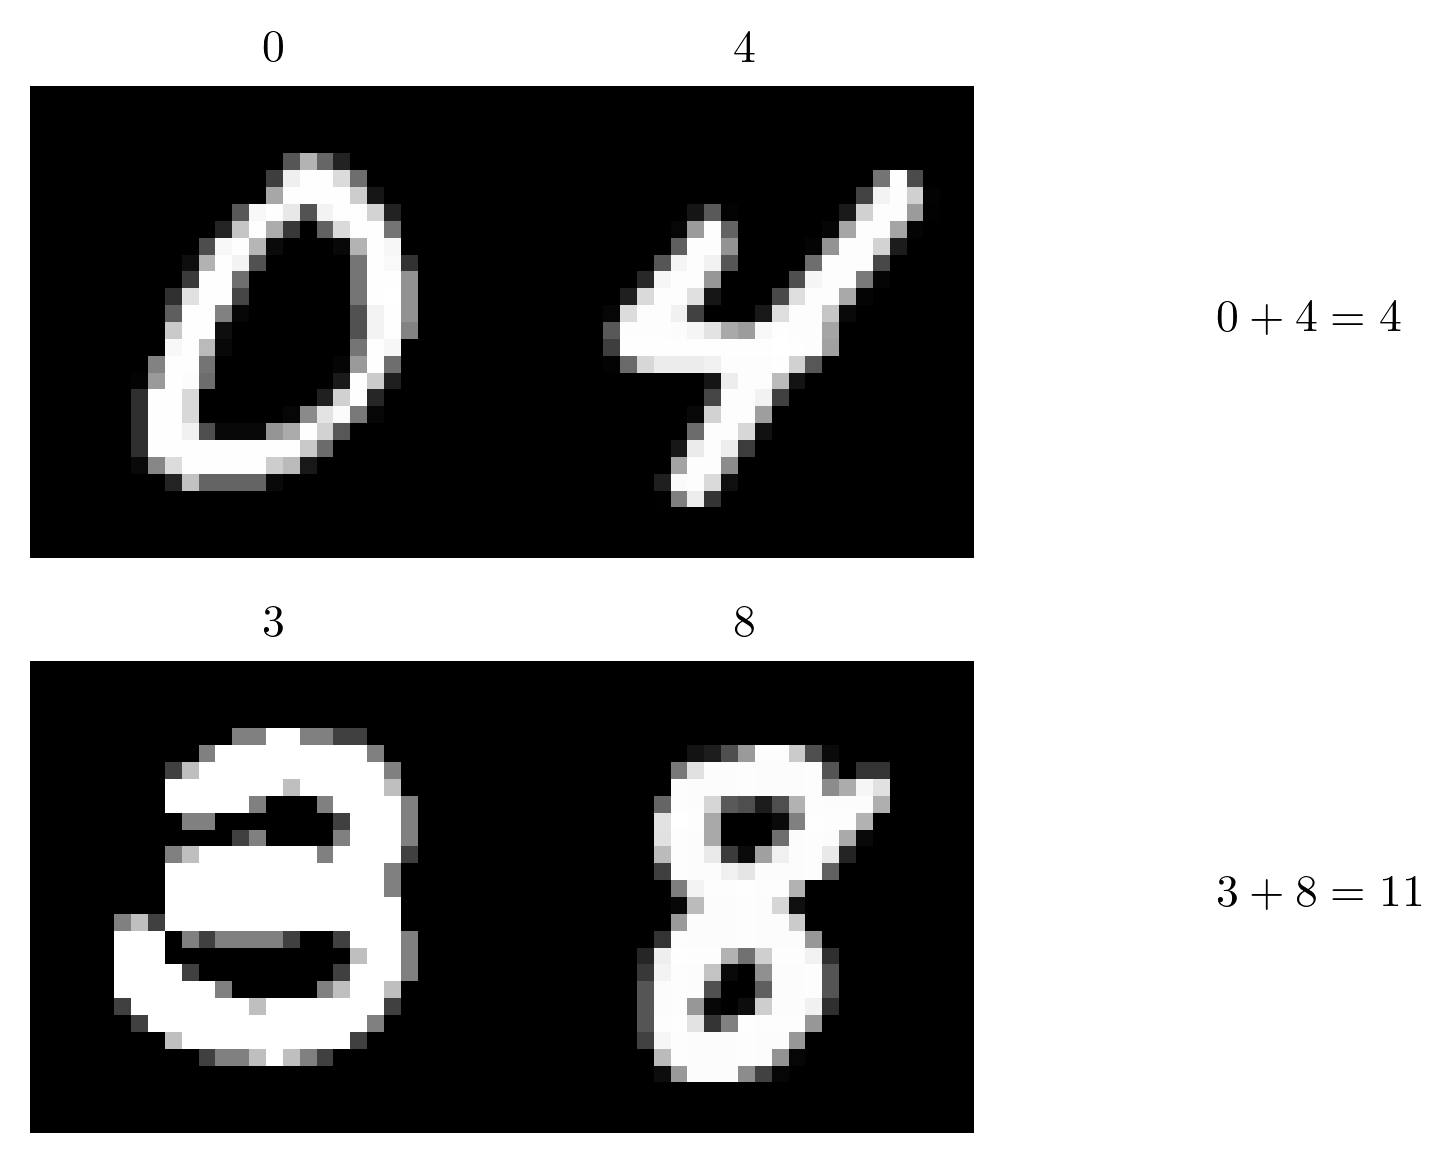

In [9]:
# Create dataset
dataset = MNISTAdditionDataset(seed=seed)
data = dataset.create_datasets()

# Visualize some examples
plot_sample_additions(data['train'][0], data['train'][1], data['train'][2], num_samples=2)

# Print data shapes and ranges
print("Data shapes:")
print(f"Training images: {data['train'][0].shape}")
print(f"Training labels: {data['train'][1].shape}\n")

print("Value ranges:")
print(f"Image min: {data['train'][0].min():.3f}, max: {data['train'][0].max():.3f}")
print(f"Label min: {data['train'][1].min()}, max: {data['train'][1].max()}")

# Neural Network Architecture

Here we will create a simple MLP with 3 layers. 

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation


In [11]:
# Create TensorFlow datasets
train_ds = dataset.get_tf_dataset(data['train'][0], data['train'][1])
val_ds = dataset.get_tf_dataset(data['val'][0], data['val'][1])
test_ds = dataset.get_tf_dataset(data['test'][0], data['test'][1], shuffle=False)

num_classes = 19

# Define the model
model = Sequential([
    Input(shape=(28, 56)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-6)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(num_classes, activation='softmax'),
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1568)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       200,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 220,819 (862.57 KB)

 Trainable params: 220,307 (860.57 KB)

 Non-trainable params: 512 (2.00 KB)

In [12]:
# Optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the model
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2656 - loss: 2.4156 - val_accuracy: 0.6651 - val_loss: 1.1016
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5866 - loss: 1.3114 - val_accuracy: 0.7472 - val_loss: 0.8453
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6705 - loss: 1.0714 - val_accuracy: 0.7864 - val_loss: 0.7112
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7210 - loss: 0.9179 - val_accuracy: 0.8210 - val_loss: 0.5968
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7505 - loss: 0.8277 - val_accuracy: 0.8483 - val_loss: 0.5276
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7746 - loss: 0.7522 - val_accuracy: 0.8502 - val_loss: 0.4969
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7929 - loss: 0.6998 - val_accuracy: 0.8608 - val_loss: 0.4800
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8020 - loss: 0.6704 - 

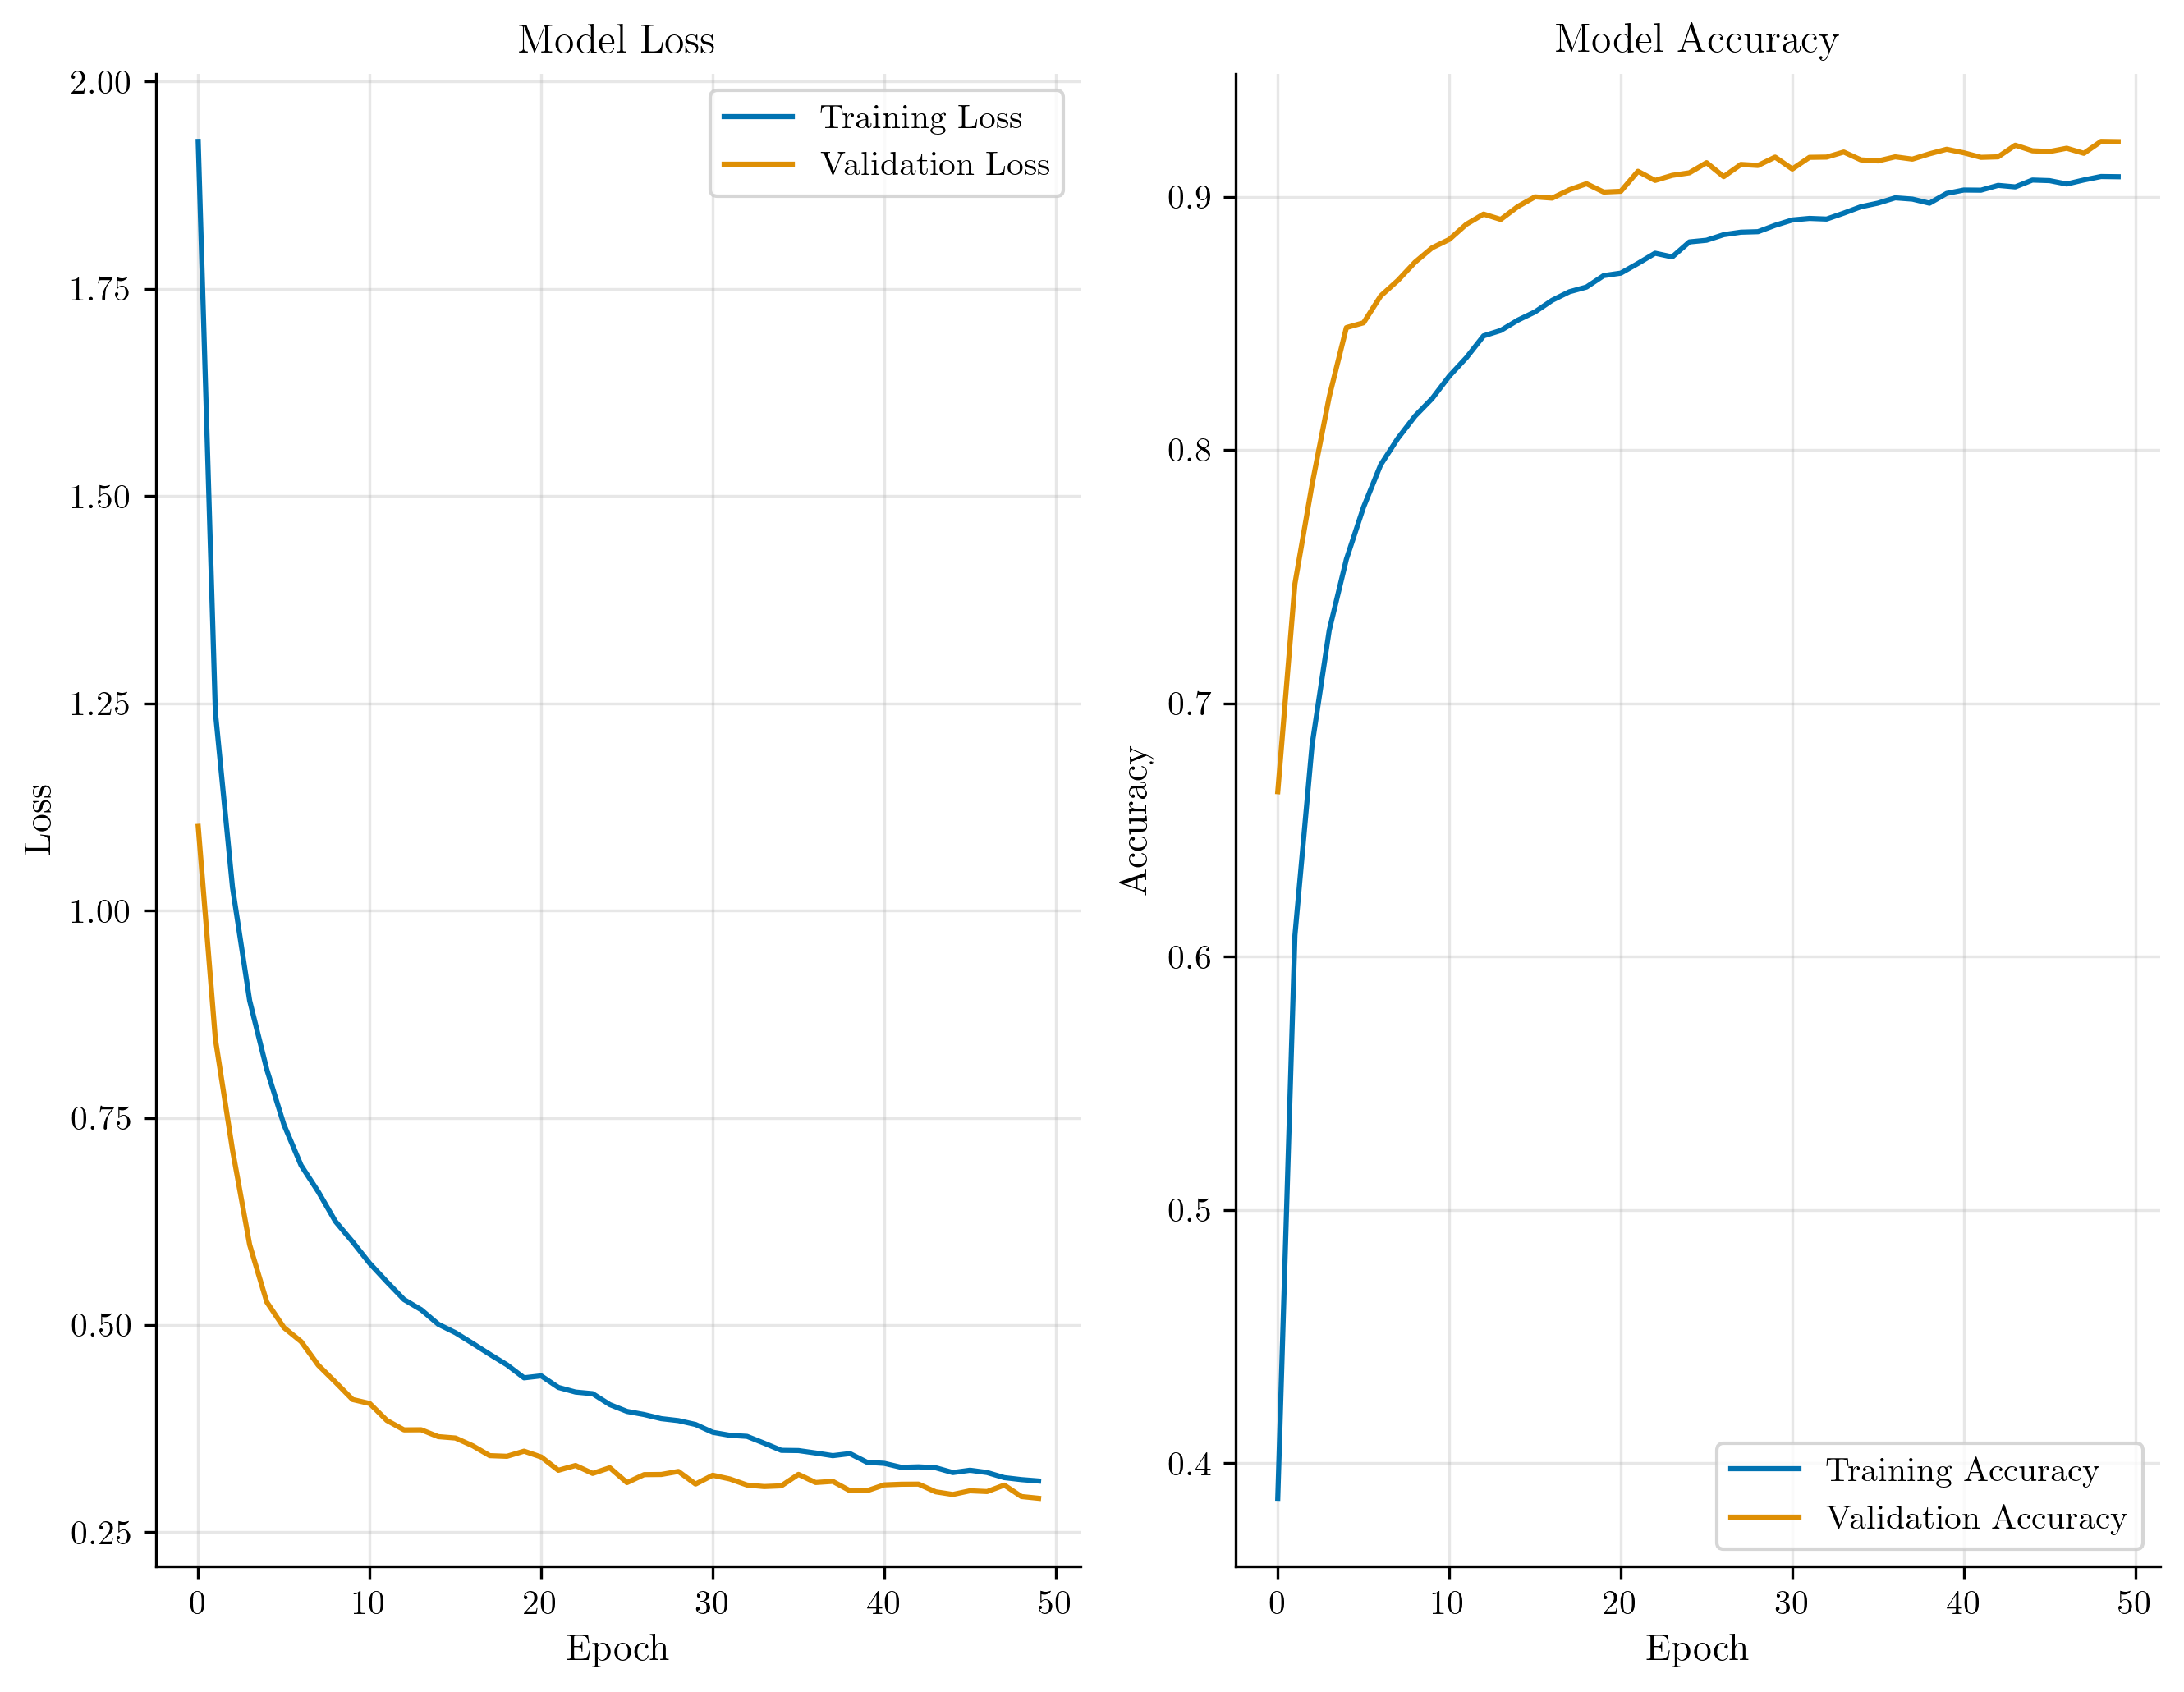

In [13]:
fig = plot_training_history(history)

Test accuracy: 0.9111
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       110
           1       0.95      0.98      0.97       248
           2       0.93      0.96      0.94       360
           3       0.93      0.94      0.94       436
           4       0.91      0.94      0.93       507
           5       0.93      0.93      0.93       615
           6       0.92      0.92      0.92       659
           7       0.91      0.94      0.92       816
           8       0.92      0.92      0.92       919
           9       0.91      0.90      0.90       994
          10       0.91      0.90      0.90       863
          11       0.90      0.89      0.90       785
          12       0.89      0.88      0.88       688
          13       0.91      0.90      0.90       576
          14       0.92      0.88      0.90       439
          15       0.88      0.90      0.89   

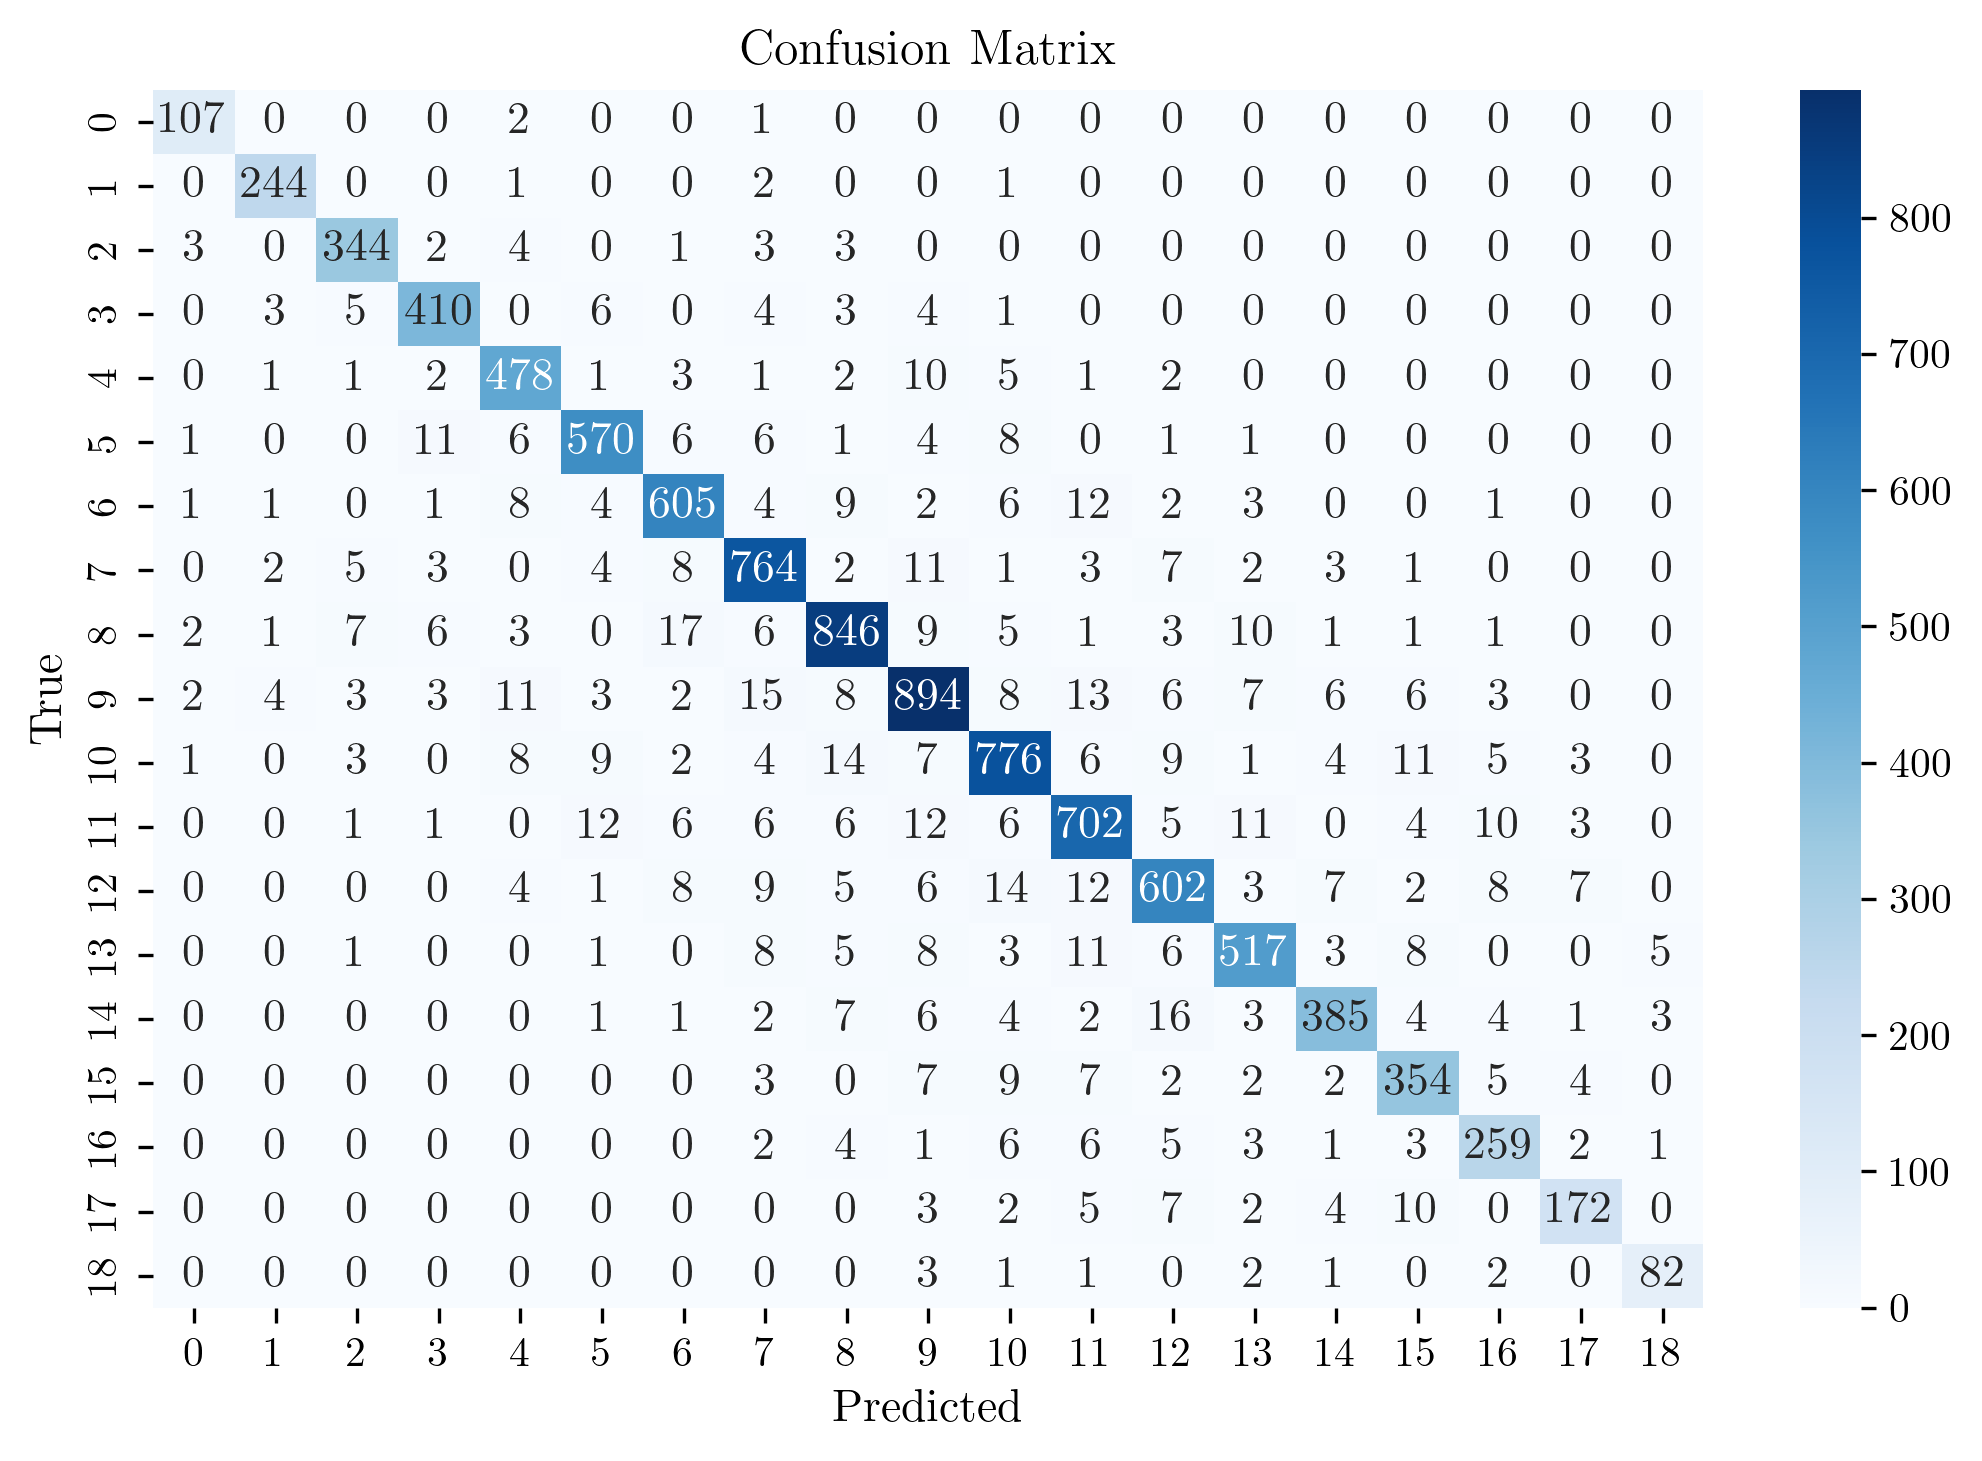

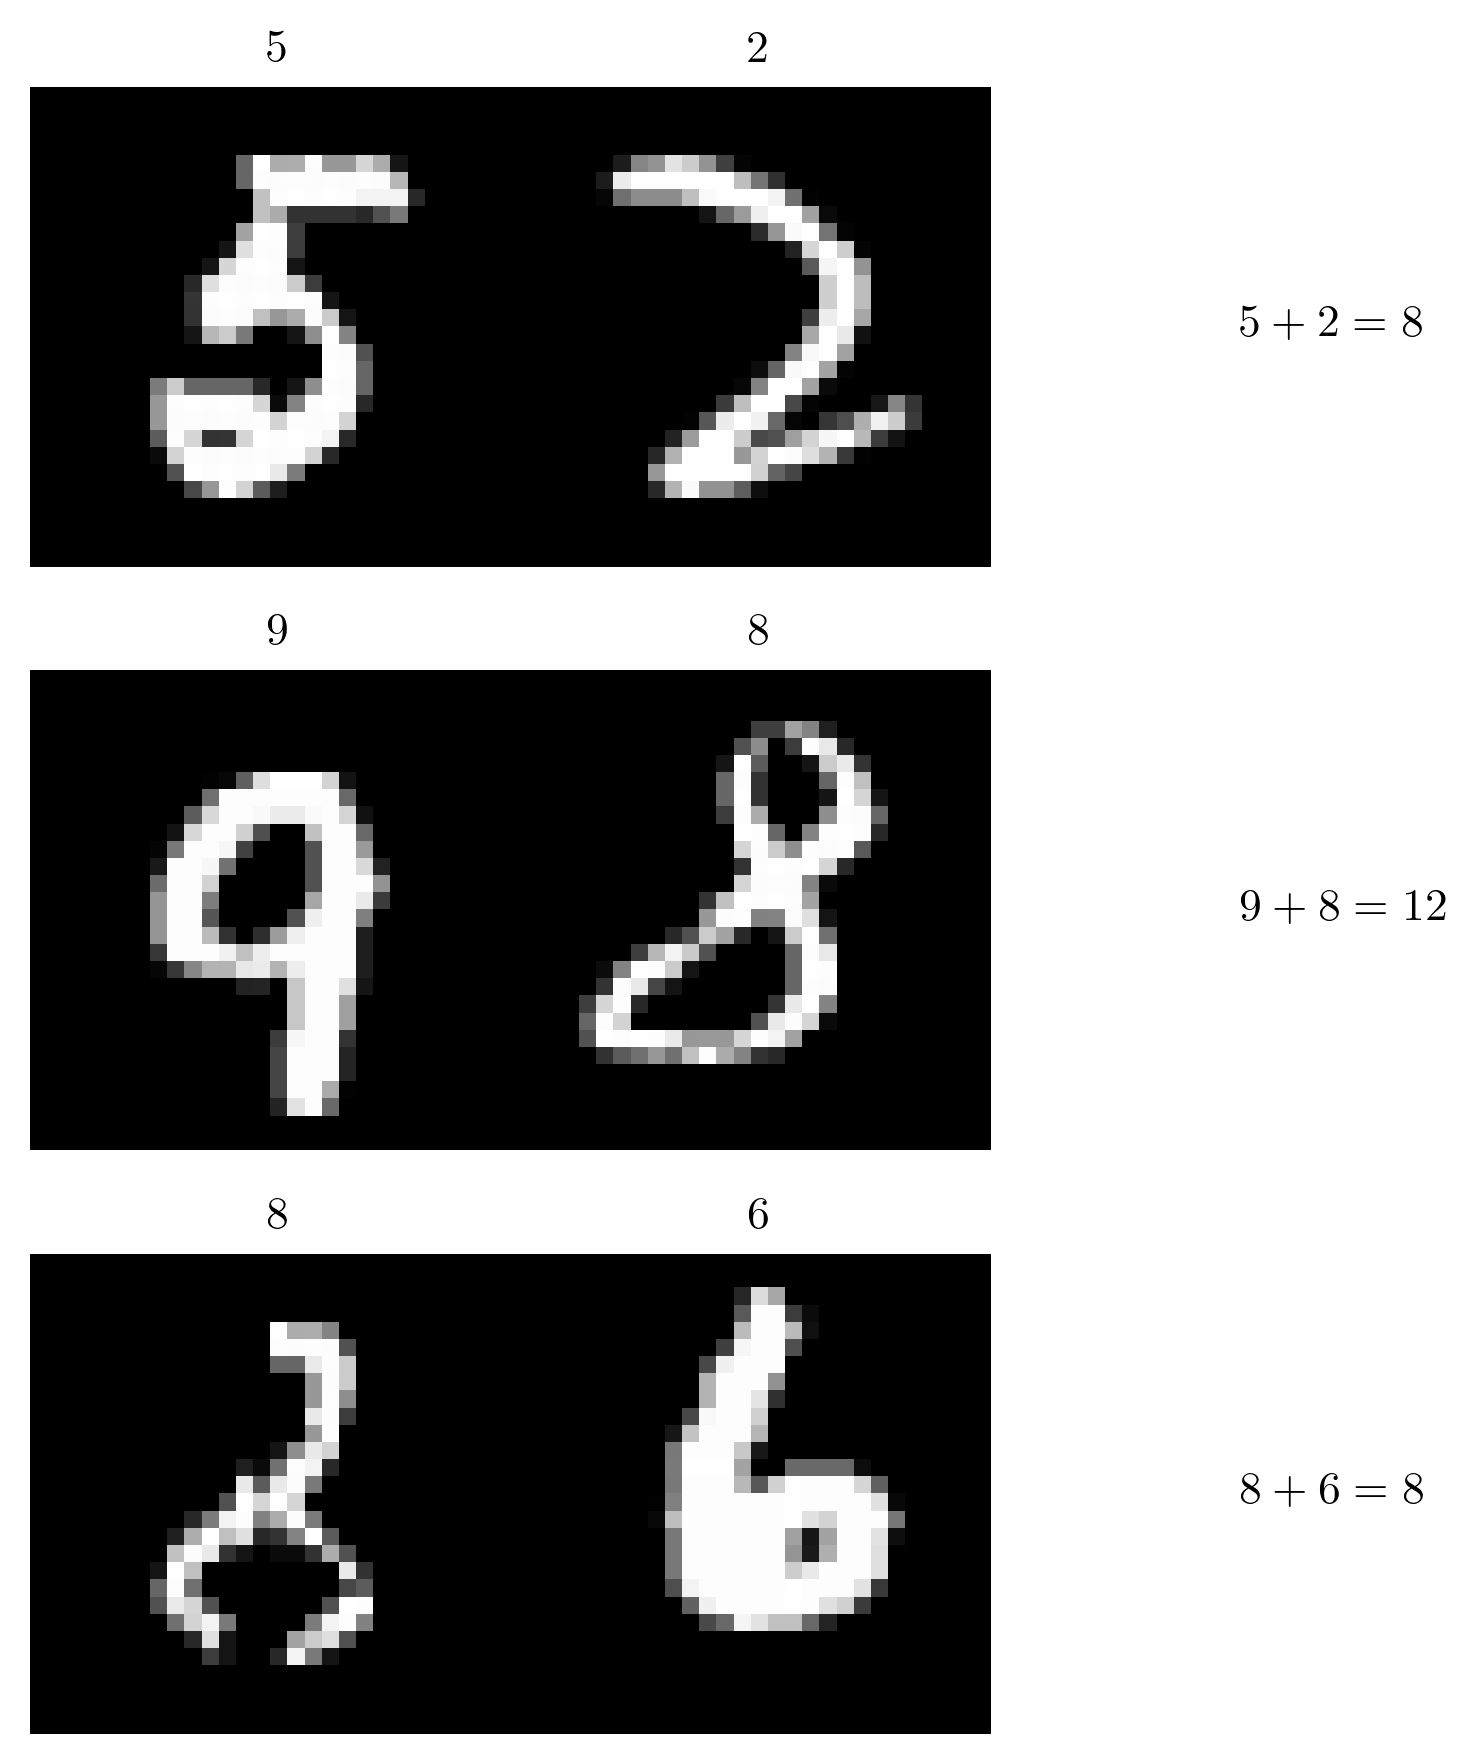

In [14]:
# Evaluate model performance on test set
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")

# Get predictions
y_pred = model.predict(data['test'][0])
y_pred_classes = tf.argmax(y_pred, axis=1).numpy()

# Plot confusion matrix
fig = plot_confusion_matrix(data['test'][1], y_pred_classes, verbose=True)
# Visualize incorrect predictions
fig = visualize_incorrect_predictions(
    data['test'][0],
    y_pred_classes,
    data['test'][1],
    data['test'][2]
)